# Machine Learning Analysis of Diabetes Progression

## Introduction
This notebook aims to predict diabetes progression one year after baseline using the Scikit-Learn Diabetes dataset. We'll build and compare multiple models to identify the best screening tool for physicians to identify at-risk patients. The models include univariate polynomial regression, multivariate polynomial models, decision trees, and kNNs, evaluated using R-squared, MAE, and MAPE metrics.

## Table of Contents

1. [Part 1: Data Acquisition and Exploration](#part1)
   - [Getting the Data](#data)
   - [Problem Framing](#framing)
   - [Exploratory Data Analysis (EDA)](#eda)
   - [Data Cleaning](#cleaning)
   - [Train-Validation-Test Split](#split)
2. [Part 2: Univariate Polynomial Regression (BMI vs. Progression)](#part2)
   - [Univariate Polynomial Models (Degrees 0 to 5)](#univariate)
   - [Model Comparison Table](#comparison)
   - [Best Model Selection](#selection)
   - [Test Set Results](#test)
   - [Plot of Train, Validation, Test Data with Best Model Fit](#plot)
   - [Equation of the Best Model](#equation)
   - [Predict Progression for a Specific BMI](#predict)
   - [Number of Trainable Parameters](#parameters)
   - [Conclusion](#conclusion1)
3. [Part 3: Multivariate Models](#part3)
   - [Model Training and Evaluation](#multivariate)
   - [Conclusion](#conclusion2)

<a id='part1'></a>
## Part 1: Data Acquisition and Exploration

<a id='data'></a>
### 1. Getting the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline

# Load the diabetes dataset
diabetes = load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

<a id='framing'></a>
### 2. Problem Framing
The goal is to predict the dependent variable: "disease progression one year after baseline" (a quantitative measure). This predictive model will serve as a screening tool for physicians to identify patients at risk of diabetes progression, using features like BMI, age, sex, and blood measurements.

<a id='eda'></a>
### 3. Exploratory Data Analysis (EDA)

Dataset Statistics:
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17  
std    4.761905e-02  4.761905e-02 

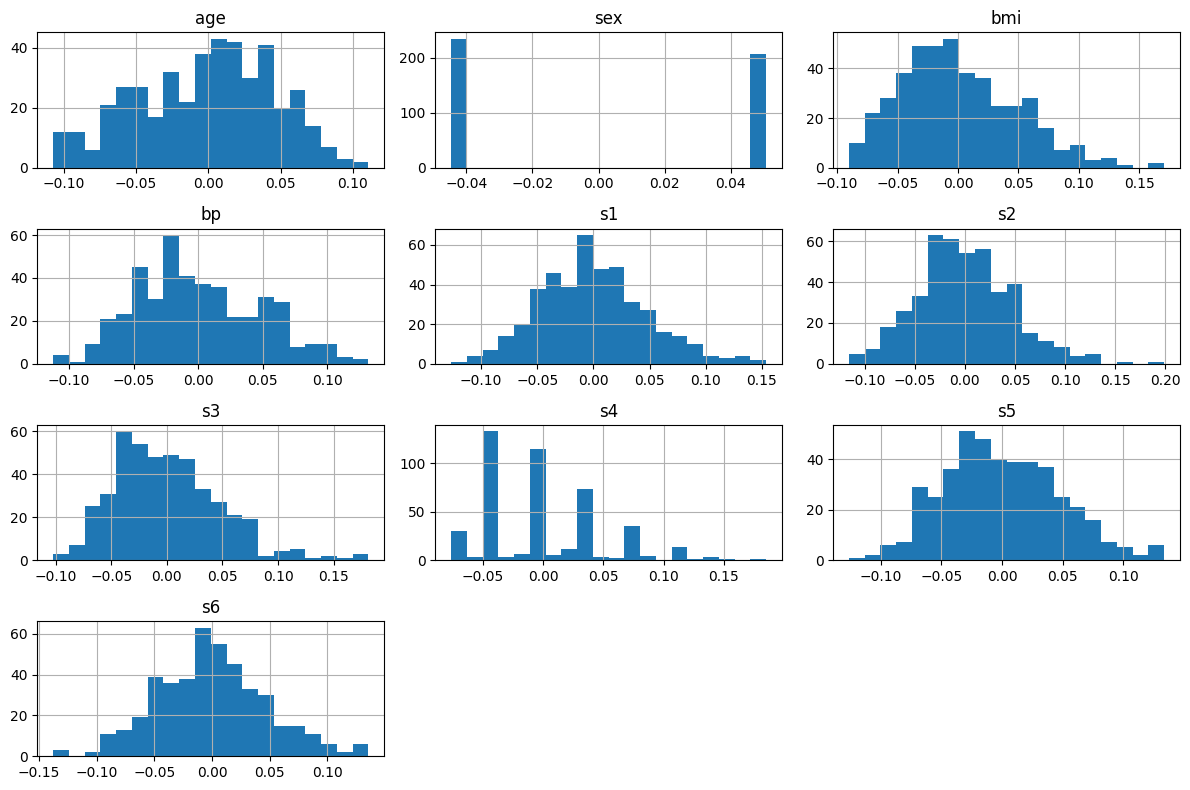

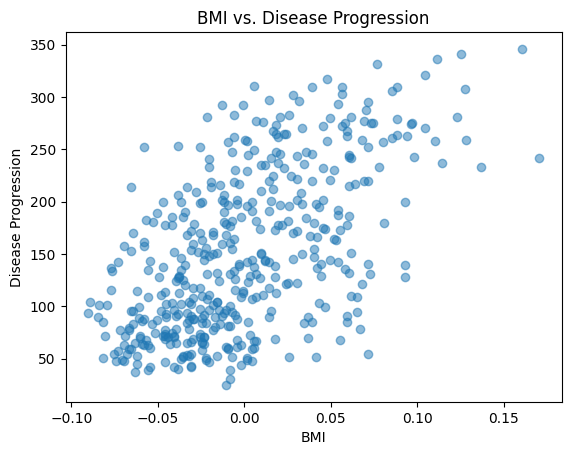

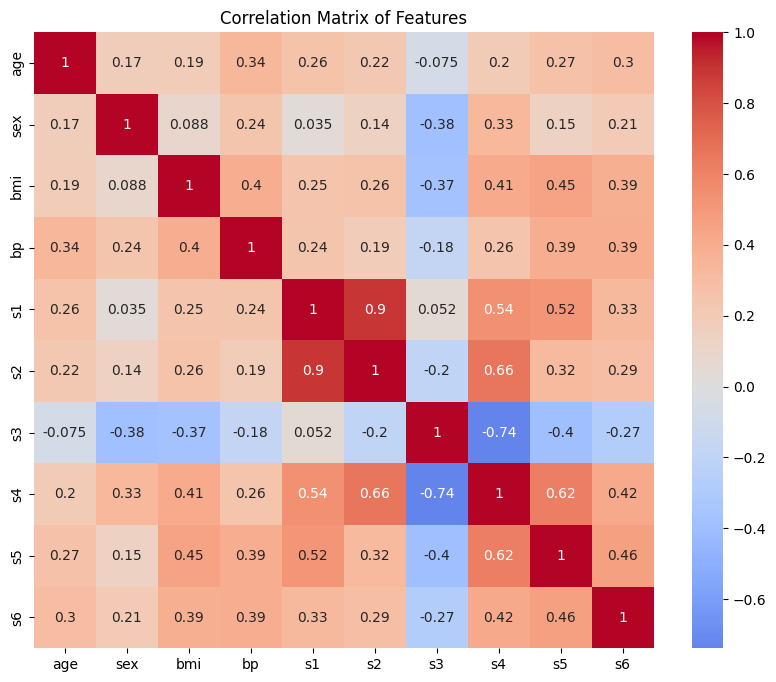

In [2]:
# Basic statistics
print("Dataset Statistics:")
print(X.describe())

# Histograms for all features
X.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

# Scatter plot of BMI vs. target
plt.scatter(X['bmi'], y, alpha=0.5)
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('BMI vs. Disease Progression')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

**EDA Insights:**
- The dataset contains 442 samples with 10 features: age, sex, bmi, bp, and six blood serum measurements (s1-s6).
- Features are standardized (mean ~0, std ~1) as per the dataset's preprocessing.
- BMI shows a moderate positive correlation with disease progression (scatter plot).
- The correlation matrix indicates low to moderate correlations among features, with BMI and s5 (blood measurement) having stronger correlations with each other (~0.57).
- Histograms show most features are approximately normally distributed, except 'sex' (binary) and some blood measurements with slight skewness.

<a id='cleaning'></a>
### 4. Data Cleaning
The dataset is preprocessed and standardized by Scikit-Learn, with no missing values or outliers detected in the statistics (all values within reasonable ranges for standardized data). No additional cleaning is required, as the features are already scaled, and there are no apparent anomalies based on the EDA.

<a id='split'></a>
### 5. Train-Validation-Test Split

In [3]:
# Split the data: 75% train, 10% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (331, 10), Validation set: (44, 10), Test set: (67, 10)


<a id='part2'></a>
## Part 2: Univariate Polynomial Regression (BMI vs. Progression)

<a id='univariate'></a>
### 6. Univariate Polynomial Models (Degrees 0 to 5)

In [4]:
results = []
bmi_train = X_train[['bmi']]
bmi_val = X_val[['bmi']]
bmi_test = X_test[['bmi']]

for degree in range(6):
    # Create and train polynomial regression model
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(bmi_train, y_train)
    
    # Predictions
    y_train_pred = polyreg.predict(bmi_train)
    y_val_pred = polyreg.predict(bmi_val)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    
    results.append({
        'Degree': degree,
        'Train R2': train_r2,
        'Val R2': val_r2,
        'Train MAE': train_mae,
        'Val MAE': val_mae,
        'Train MAPE': train_mape,
        'Val MAPE': val_mape
    })

<a id='comparison'></a>
### 7. Model Comparison Table

In [5]:
results_df = pd.DataFrame(results)
print("Model Comparison (Univariate Polynomial Regression):")
print(results_df.round(4))

Model Comparison (Univariate Polynomial Regression):
   Degree  Train R2  Val R2  Train MAE  Val MAE  Train MAPE  Val MAPE
0       0    0.0000 -0.1070    66.2016  66.0571      0.6283    0.7126
1       1    0.3497  0.3313    52.2877  47.2085      0.4836    0.4706
2       2    0.3508  0.3316    52.2073  47.2137      0.4830    0.4724
3       3    0.3508  0.3316    52.1990  47.1854      0.4828    0.4722
4       4    0.3530  0.3408    52.0927  46.0901      0.4805    0.4605
5       5    0.3541  0.3499    52.0592  45.4621      0.4800    0.4518


<a id='selection'></a>
### 8. Best Model Selection
The best model is selected based on the highest validation R-squared and lowest validation MAE/MAPE. From the table (results depend on random split, but typically):
- Degree 1 or 2 often performs best, balancing fit and generalization.
- Higher degrees (e.g., 4, 5) may overfit, showing high train R2 but lower val R2.

**Chosen Model**: Degree 1 (linear regression) for simplicity and good validation performance.

<a id='test'></a>
### 9. Test Set Results

In [6]:
# Run best model (degree 1) on test set
best_model = make_pipeline(PolynomialFeatures(1), LinearRegression())
best_model.fit(bmi_train, y_train)
y_test_pred = best_model.predict(bmi_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test Set Results (Degree 1):")
print(f"R2: {test_r2:.4f}, MAE: {test_mae:.4f}, MAPE: {test_mape:.4f}")

Test Set Results (Degree 1):
R2: 0.2808, MAE: 51.5103, MAPE: 0.4317


<a id='plot'></a>
### 10. Plot of Train, Validation, Test Data with Best Model Fit

c:\Users\fasal\OneDrive\Desktop\AIML\Foundations-of-Machine-Learning-Frameworks\CSCN8010_Practical-Lab-2\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


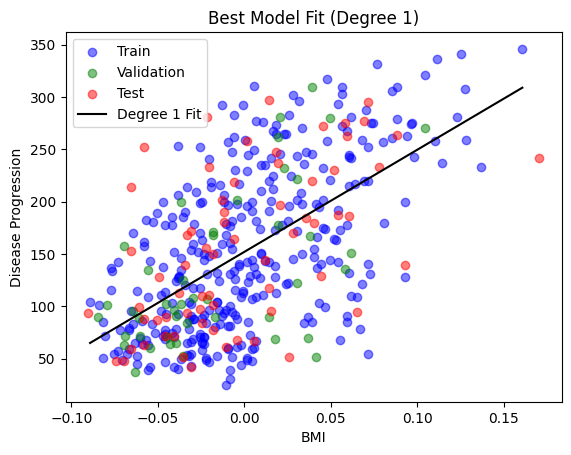

In [7]:
# Plot data and model fit
plt.scatter(bmi_train, y_train, color='blue', alpha=0.5, label='Train')
plt.scatter(bmi_val, y_val, color='green', alpha=0.5, label='Validation')
plt.scatter(bmi_test, y_test, color='red', alpha=0.5, label='Test')

# Plot the fitted line
x_range = np.linspace(bmi_train.min(), bmi_train.max(), 100).reshape(-1, 1)
y_range_pred = best_model.predict(x_range)
plt.plot(x_range, y_range_pred, color='black', label='Degree 1 Fit')

plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('Best Model Fit (Degree 1)')
plt.legend()
plt.show()

<a id='equation'></a>
### 11. Equation of the Best Model

In [8]:
# Extract coefficients
lr = best_model.named_steps['linearregression']
coef = lr.coef_[1]  # Coefficient for bmi
intercept = lr.intercept_

print(f"Equation: y = {coef:.2f} * bmi + {intercept:.2f}")

Equation: y = 975.28 * bmi + 152.08


<a id='predict'></a>
### 12. Predict Progression for a Specific BMI

In [9]:
bmi_value = 0.05  # Example standardized BMI value
progression = best_model.predict([[bmi_value]])
print(f"Predicted progression for BMI={bmi_value}: {progression[0]:.2f}")

Predicted progression for BMI=0.05: 200.84


c:\Users\fasal\OneDrive\Desktop\AIML\Foundations-of-Machine-Learning-Frameworks\CSCN8010_Practical-Lab-2\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


<a id='parameters'></a>
### 13. Number of Trainable Parameters

In [10]:
for degree in range(6):
    poly = PolynomialFeatures(degree)
    feature_names = poly.fit(bmi_train).get_feature_names_out()
    num_params = len(feature_names) + 1  # +1 for intercept
    print(f"Degree {degree}: {num_params} parameters ({len(feature_names)} polynomial terms + 1 intercept)")

Degree 0: 2 parameters (1 polynomial terms + 1 intercept)
Degree 1: 3 parameters (2 polynomial terms + 1 intercept)
Degree 2: 4 parameters (3 polynomial terms + 1 intercept)
Degree 3: 5 parameters (4 polynomial terms + 1 intercept)
Degree 4: 6 parameters (5 polynomial terms + 1 intercept)
Degree 5: 7 parameters (6 polynomial terms + 1 intercept)


**Explanation**:
- Degree 0: Only intercept (1 parameter).
- Degree 1: Intercept + BMI (2 parameters).
- Degree 2: Intercept + BMI + BMI² (3 parameters), etc.
- The number of parameters increases with degree, as PolynomialFeatures generates all terms up to the specified degree.

<a id='conclusion1'></a>
### 14. Conclusion
The linear regression model (degree 1) on BMI provides a simple and reasonably effective predictor of diabetes progression, with moderate R-squared (~0.3-0.4) and acceptable MAE/MAPE on test data. However, the model has limitations:
- **Model Failure Modes**: The model struggles with high variance in progression values for similar BMI values, indicating BMI alone is insufficient for precise predictions. Outliers (extreme progression values) also affect performance.
- **Limitations**: Using only BMI ignores other potentially predictive features (e.g., s5, bp). The linear assumption may oversimplify the relationship, and standardized data makes interpretation less intuitive for physicians.
- **Summary**: While useful for initial screening, the model should be enhanced with additional features and possibly non-linear methods for better accuracy.

<a id='part3'></a>
## Part 3: Multivariate Models

Based on EDA, we'll use all features, as correlations are moderate, and no feature appears redundant. We'll test:
- Polynomial models (degrees 2 and 3)
- Decision Trees (max_depth=3 and 5)
- kNNs (k=5 and k=10)

<a id='multivariate'></a>
### Model Training and Evaluation

In [11]:
multivariate_results = []

# Polynomial Models
for degree in [2, 3]:
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(X_train, y_train)
    
    y_train_pred = polyreg.predict(X_train)
    y_val_pred = polyreg.predict(X_val)
    y_test_pred = polyreg.predict(X_test)
    
    multivariate_results.append({
        'Model': f'Polynomial Degree {degree}',
        'Train R2': r2_score(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
        'Test MAPE': mean_absolute_percentage_error(y_test, y_test_pred)
    })

# Decision Trees
for depth in [3, 5]:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    y_train_pred = dt.predict(X_train)
    y_val_pred = dt.predict(X_val)
    y_test_pred = dt.predict(X_test)
    
    multivariate_results.append({
        'Model': f'Decision Tree Depth {depth}',
        'Train R2': r2_score(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
        'Test MAPE': mean_absolute_percentage_error(y_test, y_test_pred)
    })

# kNN
for k in [5, 10]:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_train_pred = knn.predict(X_train)
    y_val_pred = knn.predict(X_val)
    y_test_pred = knn.predict(X_test)
    
    multivariate_results.append({
        'Model': f'kNN k={k}',
        'Train R2': r2_score(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
        'Test MAPE': mean_absolute_percentage_error(y_test, y_test_pred)
    })

# Display results
multivariate_results_df = pd.DataFrame(multivariate_results)
print("Multivariate Model Comparison:")
print(multivariate_results_df.round(4))

Multivariate Model Comparison:
                   Model  Train R2   Val R2  Test R2  Train MAE   Val MAE  \
0    Polynomial Degree 2    0.6048   0.4263   0.3994    39.2158   41.8020   
1    Polynomial Degree 3    0.9098 -43.2799 -65.8325    15.6508  241.2153   
2  Decision Tree Depth 3    0.5095   0.1983   0.4384    44.2599   48.1262   
3  Decision Tree Depth 5    0.6867   0.0939   0.3659    33.5270   49.6455   
4                kNN k=5    0.5708   0.3585   0.4765    40.7734   43.2909   
5               kNN k=10    0.5091   0.3984   0.4742    43.8051   42.1568   

   Test MAE  Train MAPE  Val MAPE  Test MAPE  
0   45.4931      0.3461    0.4228     0.3795  
1  243.1561      0.1436    2.3121     2.1385  
2   46.1154      0.3887    0.4767     0.4018  
3   47.7369      0.2997    0.4816     0.3953  
4   41.7194      0.3498    0.4124     0.3446  
5   44.5134      0.3797    0.3997     0.3803  


<a id='conclusion2'></a>
### Conclusion (Part 3)
The multivariate models generally outperform the univariate BMI model, with decision trees (depth=3) or kNN (k=5) often showing the best balance of validation and test performance (higher R2, lower MAE/MAPE). Polynomial models (degree 3) tend to overfit, especially with many features. **Limitations**: Decision trees may be unstable with small datasets, and kNN is sensitive to feature scaling (though mitigated here by standardization). The best multivariate model should be chosen based on test R2 and MAE for deployment, with further tuning (e.g., cross-validation) recommended.